In [1]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import os
import cv2
import skimage.morphology
from skimage import measure
from skimage import io, filters
import scipy
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import imutils

# [IAPR][iapr]: Project


**Group ID:** 14

**Author 1 (sciper):** David Rüegg (218512)  
**Author 2 (sciper):** Yacine Derder (301994)   
**Author 3 (sciper):** Elsa Pariat (301964)   

**Release date:** 27.04.2023


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

In this project, you will be working on solving tiling puzzles using image analysis and pattern recognition techniques. Tiling puzzles are a classic type of puzzle game that consists of fitting together pieces of a given shape (in this case squared to form a complete image. The goal of this project is to develop an algorithm that can automatically reconstruct tiling puzzles from a single input image. 

---

## 1. Data

### Input data
To achieve your task, you will be given images that look like this:


![train_00.png](data_project/project_description/train_00.png)

### Example puzzle content
Example of input of solved puzzles. 
Solution 1
<img src="data_project/project_description/solution_example.png" width="512"/>
Solution 2
<img src="data_project/project_description/solution_example2.jpg" width="512"/>


### 1.1. Image layout

- The input for the program will be a single image with a size of __2000x2000 pixels__, containing the pieces of the tiling puzzles randomly placed in it. The puzzles sizes vary from __3x3, 3x4, or 4x4__ size. 
    -__You are guaranteed to always have the exact number of pieces for each puzzle__ 
        -For each puzzle you always are expected to find exaclty 9,12,16 pieces
        -If you find something else, either you are missing pieces, or added incorrect pieces for the puzzle

- The puzzle pieces are square-shaped with dimensions of 128x128 pixels (before rotation). 

- The input image will contain pieces from __two or three (but never four)__ different tiling puzzles, as well as some __extra pieces (outliers)__ that do not belong to either puzzle.


## 2. Tasks (Total 20 points) 


The project aims to:
1) Segment the puzzle pieces from the background (recover the pieces of 128x128 pixels)   \[ __5 points__ \] 

2) Extract features of interest from puzzle pieces images \[ __5 points__ \]   

3) Cluster puzzle pieces to identify which puzzle they belong, and identify outliers.  \[ __5 points__ \]   

4) Solve tiling puzzle (find the rotations and translations to correctly allocate the puzzle pieces in a 3x3, 3x4 or 4x4 array.) \[ __5 points__ \]   

##### The images used for the puzzles have self-repeating patterns or textures, which ensures that all puzzle pieces contain more or less the same features regardless of how they were cut. 




### 1.2. Output solution pieces.

For each inpute image, the output solution will include N images with solved puzzles, where N is the number of puzzles in the input image. and M images, that are Each of these images will contain the solved solution to one of the N puzzles in the input. 


-  Example input:  train_05.png

- Example solution:
        -solution_05_00.png solution_05_01.png solution_05_02.png 
        -outlier_05_00.png outlier_05_01.png outlier_05_02.png ...

- Example input:  train_07.png
- Example solution:
        -solution_07_00.png solution_07_01.png 
        -outlier_07_00.png outlier_07_01.png outlier_07_02.png ...


__Watch out!__ output resolution should always be like this:  
<table ><tr><th >Puzzle pieces <th><th> pixel dimentions <th> <th> pixel dimentions <th> <tr>
<tr><td> 3x3 <td><td> 384x384 <td><td> 3(128)x3(128) <td> <tr>
<tr><td> 3x4 <td><td> 384x512 <td><td> 3(128)x4(128)<tr>
<tr><td> 4x4 <td><td> 512x512 <td><td> 4(128)x4(128)<tr>
<tr><td> 1x1 (outlier)<td><td> 128x128 <td><td> (1)128x(1)128 <td><tr><table>





__Order of the solutions (and rotations) it's not a problem for the grading__




the output solution will be a final image of resolution (1283)x(1283), with each piece correctly placed in its corresponding location in the 3x3 array. Similarly, if the puzzle consists of 3x4 or 4x4 pieces, the output solution will be an image of resolution (1283)x(1284) or (1284)x(1284)



### 1.3 Data folder Structure

You can download the data for the project here: [download data](https://drive.google.com/drive/folders/1k3xTH0ZhpqZb3xcZ6wsOSjLzxBNYabg3?usp=share_link)

```
data_project
│
└─── project_description
│    │    example_input.png      # example input images
│    │    example_textures1.png      # example input images
│    │    example_textures2.png      # example input images
│    └─── ultimate_test.jpg   # If it works on that image, you would probably end up with a good score
│
└─── train
│    │    train_00.png        # Train image 00
│    │    ...
│    │    train_16.png        # Train image 16
│    └─── train_labels.csv    # Ground truth of the train set
|    
└────train_solution
│    │    solution_00_00.png        # Solution puzzle 1 from Train image 00
│    │    solution_00_01.png        # Solution puzzle 2 from Train image 00
│    │    solution_00_02.png        # Solution Puzzle 3 from Train image 00
│    │    outlier_00_00.png         # outlier     from Train image 00
│    │    outlier_00_01.png         # outlier     from Train image 00
│    │    outlier_00_03.png         # outlier     from Train image 00
│    │    ...
│    │    solution_15_00.png        # Solution puzzle 1 from Train image 15
│    │    solution_15_01.png        # Solution puzzle 2 from Train image 15
│    │    outlier_15_00.png         # outlier     from Train image 15
│    └─── outlier_15_01.png         # outlier     from Train image 15
│
└─── test
     │    test_00.png         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx.png             # Test image xx (day of the exam only)
```



## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** (test folder) with few images, but **no ground truth** (no solutions).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_solution** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---


## 4. Your code

In [2]:
## load images
import os 
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt


In [3]:

def load_input_image(image_index ,  folder ="train2" , path = "data_project"):
    
    filename = "train_{}.png".format(str(image_index).zfill(2))
    path_solution = os.path.join(path,folder , filename )
    
    im= Image.open(os.path.join(path,folder,filename)).convert('RGB')
    im = np.array(im)
    return im

def save_solution_puzzles(image_index , solved_puzzles, outliers  , folder ="train2" , path = "data_project"  ,group_id = 0):
    
    path_solution = os.path.join(path,folder + "_solution_{}".format(str(group_id).zfill(2)))
    if not  os.path.isdir(path_solution):
        os.mkdir(path_solution)

    print(path_solution)
    for i, puzzle in enumerate(solved_puzzles):
        filename =os.path.join(path_solution, "solution_{}_{}.png".format(str(image_index).zfill(2), str(i).zfill(2)))
        Image.fromarray(puzzle).save(filename)

    for i , outlier in enumerate(outliers):
        filename =os.path.join(path_solution, "outlier_{}_{}.png".format(str(image_index).zfill(2), str(i).zfill(2)))
        Image.fromarray(outlier).save(filename)


In [4]:
def solve_and_export_puzzles_image(image_index , folder = "train2" , path = "data_project"  , group_id = "00"):
    """
    Wrapper funciton to load image and save solution
            
    Parameters
    ----------
    image:
        index number of the dataset

    Returns
    """

      # open the image
    image_loaded = load_input_image(image_index , folder = folder , path = path)
    #print(image_loaded)
    
   
    ## call functions to solve image_loaded
    solved_puzzles = [ (np.random.rand(512,512,3)*255).astype(np.uint8)  for i in range(2) ]
    outlier_images = [ (np.random.rand(128,128,3)*255).astype(np.uint8) for i in range(3)]
    
    save_solution_puzzles (image_index , solved_puzzles , outlier_images , folder = folder ,group_id =group_id)
    
   
    
    
    
    return image_loaded , solved_puzzles , outlier_images

im, sol , out = solve_and_export_puzzles_image(6 , group_id = 6)

data_project\train2_solution_06


In [5]:
group_id = 14
# Evaluate all images
games_id = [6,10]  # to evaluate  three images

for i in games_id :
    
    print("solving " , i)
    # Saving results
    solve_and_export_puzzles_image(6 , group_id = group_id)
  


solving  6
data_project\train2_solution_14
solving  10
data_project\train2_solution_14


## Evaluation metrics

The evaluation metrics will be liberated in the following days. 


## Gabor filters

$$ gb(x,y) = \exp \left( -\frac{1}{2} \left( \frac{x_{\theta}^2}{\sigma^2} + \frac{y_{\theta}^2}{(\Gamma\sigma)^2} \right) \right) \cos \left( \frac{2 \pi}{\lambda} x_{\theta} + \psi \right) $$


C:\Users\yacin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


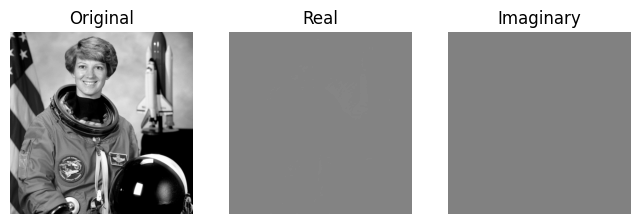

In [6]:
from skimage.filters import gabor
from skimage import data, io, color

image = color.rgb2gray(data.astronaut())

# Define the parameters for the Gabor filter
frequency = 0.6
theta = np.pi / 4
bandwidth = 1
sigma_x = 5
sigma_y = 5

# Apply the Gabor filter to the image
real, imag = gabor(image, frequency=frequency, theta=theta,
                   bandwidth=bandwidth, sigma_x=sigma_x, sigma_y=sigma_y)

# Plot the original image and the filtered images
fig, (ax_orig, ax_real, ax_imag) = plt.subplots(ncols=3, figsize=(8, 4),
                                                 sharex=True, sharey=True)
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.axis('off')

ax_real.imshow(real, cmap='gray')
ax_real.set_title('Real')
ax_real.axis('off')

ax_imag.imshow(imag, cmap='gray')
ax_imag.set_title('Imaginary')
ax_imag.axis('off')

plt.show()


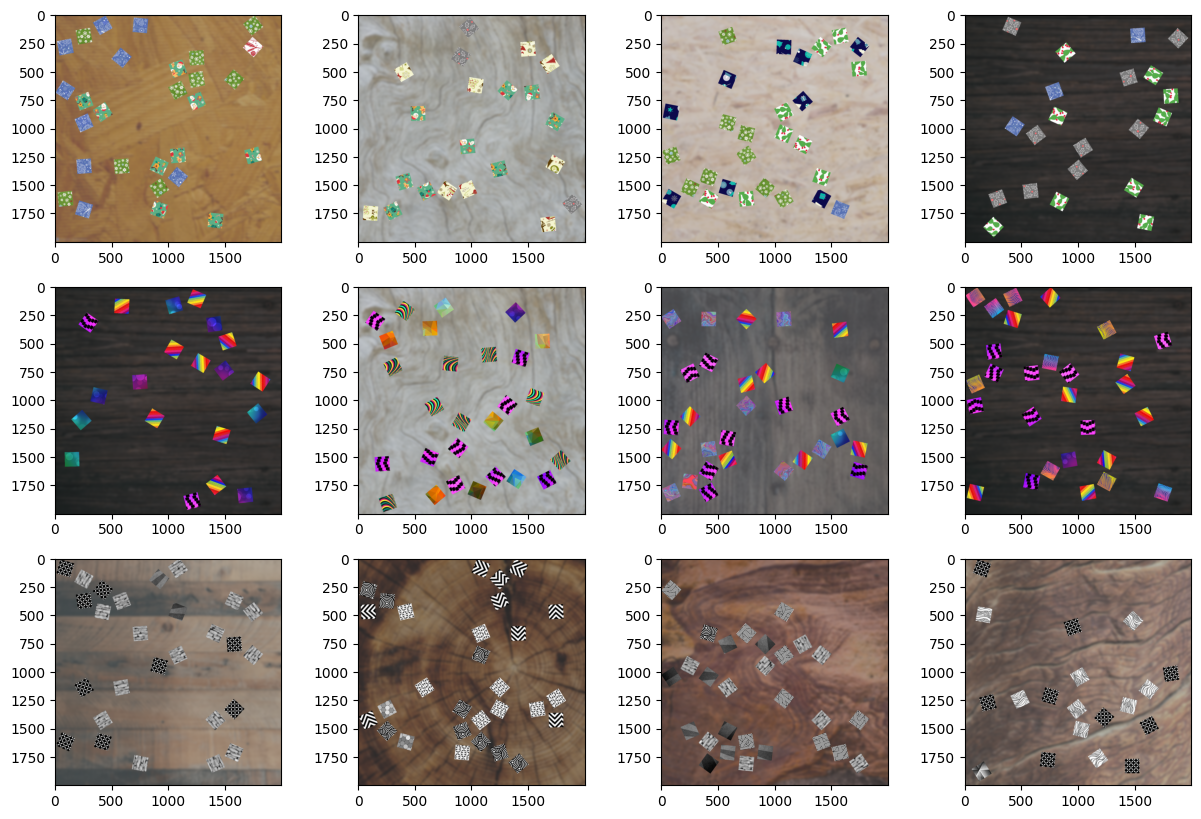

In [84]:
# Plot all input images

# Get number of train inputs
dir_path = r'data_project\train2'
nb_train_samples = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

fig, ax = plt.subplots(3, 4, figsize = (15,10))
for i in range(3):
    for j in range(4):
        ax[i,j].imshow(load_input_image(4*i + j))
    
plt.show()

In [154]:
def preprocess(img, th_val = 75, trans="rgb", c_k_size=20, o_k_size=5):
    if trans[:3] == "rgb":
        mean_rgb = np.mean(img, axis=(0,1))
        pix_dist = np.linalg.norm(img - mean_rgb, axis = 2)
    elif trans[:3] == "hsv":
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mean_hsv = np.mean(hsv, axis=(0,1))
        pix_dist = np.linalg.norm(hsv - mean_hsv, axis = 2)
    elif trans[:3] == "all":
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img_all = np.concatenate((img, hsv), axis=2)
        mean_all = np.mean(img_all, axis=(0,1))
        pix_dist = np.linalg.norm(img_all - mean_all, axis = 2)
    else:
        raise Exception("Invalid Transformation")
    
#     print(np.max(pix_dist))
#     print(np.min(pix_dist))
    
    # Threshold
    im_prep = np.zeros_like(pix_dist)
    if trans[len(trans)-3:len(trans)] == "esh":
        th_val = filters.threshold_otsu(pix_dist.flatten())
#     else:
#         th_val = (np.max(pix_dist) + np.min(pix_dist)) / 2
    im_prep[pix_dist > th_val] = 255
    
    # Remove small holes and objects
    im_prep = skimage.morphology.remove_small_holes(im_prep.astype(bool), area_threshold=10000).astype(float)*255
#     im_prep = skimage.morphology.remove_small_objects(im_prep.astype(bool), min_size=100).astype(float)*255
    
    # Close then open
    kernel = np.ones((c_k_size,c_k_size), np.uint8)
    im_prep = cv2.morphologyEx(im_prep, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((o_k_size,o_k_size), np.uint8)
    im_prep = cv2.morphologyEx(im_prep, cv2.MORPH_OPEN, kernel)
    
    # Remove small holes and objects
    im_prep = skimage.morphology.remove_small_holes(im_prep.astype(bool), area_threshold=10000).astype(float)*255
    
    # Remove small holes and objects
    kernel = np.ones((o_k_size,o_k_size), np.uint8)
    im_prep = cv2.dilate(im_prep,kernel,iterations = 1)
    im_prep = skimage.morphology.remove_small_holes(im_prep.astype(bool), area_threshold=10000).astype(np.uint8)*255
    im_prep = cv2.erode(im_prep,kernel,iterations = 1)
    
    return im_prep

In [155]:
def comb_transf(img):
    transforms = ["rgb", "rgb + auto_thresh", "hsv", "hsv + auto_thresh", "all", "all + auto_thresh"]
#     transforms = ["rgb", "hsv", "all"]
#     transforms = ["rgb + auto_thresh", "hsv + auto_thresh", "all + auto_thresh"]
    
    im_prep = np.zeros([img.shape[0], img.shape[1], len(transforms)])
    for i in range(len(transforms)):
        im_prep[:,:,i] = preprocess(img, trans=transforms[i])
    
    im_comb = np.round(np.mean(im_prep, axis=2)/255)*255
    
    return im_comb

In [156]:
# Test
im_prep = comb_transf(load_input_image(1))

print(f"Chosen preprocessing : {sel_trans}")
resized = cv2.resize(im_prep, (800,800))
cv2.imshow('Preprocessed Image', resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

Chosen preprocessing : all


In [140]:
# Evaluation for all samples
for i in range(nb_train_samples):
    im_prep = comb_transf(load_input_image(i))
    
    resized = cv2.resize(im_prep, (800,800))
    cv2.imshow(f'Image {i}', resized)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    print(f"Image {i} \n")

Image 0 

Image 1 

Image 2 

Image 3 

Image 4 

Image 5 

Image 6 

Image 7 

Image 8 

Image 9 

Image 10 

Image 11 



In [134]:
def isolate_pieces(original):
    pieces = []
    im_prep = comb_transf(original)
    im_prep = im_prep.astype(np.uint8)
    contours, _ = cv2.findContours(im_prep, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Find the initial centroids
    p_pos = np.zeros([len(contours), 2])
    for idx, contour in enumerate(contours):
        canvas = np.zeros_like(im_prep)
        cv2.fillPoly(canvas, [contour], color=(255))

        moments = cv2.moments(contour)
        cx = moments['m10'] / moments['m00']
        cy = moments['m01'] / moments['m00']

        p_pos[idx,:] = [cx, cy]

    # Merge pieces that are very close together using DBSCAN
    db = DBSCAN(eps=100, min_samples=1).fit(p_pos)

    merged_contours = []
    merged_contours_areas = []
    for labs in range(np.max(db.labels_)+1):
        to_merge = np.where(db.labels_ == labs)[0]
        merged_i = contours[to_merge[0]]
        for i in range(1,len(to_merge)):
            merged_i = np.concatenate((merged_i, contours[to_merge[i]]), axis=0)
        merged_contours.append(merged_i)
        merged_contours_areas.append(cv2.contourArea(merged_i))
    
    # Delete too small pieces (Noise)
    merged_contours = np.delete(merged_contours, np.array(merged_contours_areas) <= piece_dim**2/3)
    
    # Seperate pieces stuck together
#     filtered_im = np.zeros(im_prep.shape, dtype=np.uint8)
#     cv2.fillPoly(filtered_im, merged_contours, color=(255))
#     kernel = np.ones((15,15), np.uint8)
#     filtered_im = cv2.dilate(filtered_im,kernel,iterations = 1)
#     filtered_im = skimage.morphology.remove_small_holes(filtered_im.astype(bool), area_threshold=10000).astype(np.uint8)*255
#     filtered_im = cv2.erode(filtered_im,kernel,iterations = 1)
# #     filtered_im = cv2.morphologyEx(filtered_im, cv2.MORPH_OPEN, kernel)
#     merged_contours, _ = cv2.findContours(filtered_im, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Print effect of filtering
    print(f"Initial number of pieces : {len(contours)}, merged number of pieces : {len(merged_contours)}")
    
    # Crop and rotate each piece
    p_pos = np.zeros([len(contours), 2])
    for idx, contour in enumerate(merged_contours):
        # Define canvases
        canvas = np.zeros_like(im_prep)
        cv2.fillPoly(canvas, [contour], color=(255))
        canvas_real = cv2.bitwise_and(original, original, mask=canvas)

        # Find bounding boxes
        coords = cv2.findNonZero(canvas)
        x, y, w, h = cv2.boundingRect(coords)
        crop_canvas = canvas[y:y+h, x:x+w]
        crop_canvas_real = canvas_real[y:y+h, x:x+w]

        # Rotate by the right angle
        rect = cv2.minAreaRect(contour)
        angle = rect[2]
        rotated = imutils.rotate(crop_canvas, angle=angle)
        rotated_real = imutils.rotate(crop_canvas_real, angle=angle)
        coords = cv2.findNonZero(rotated)
        x, y, w, h = cv2.boundingRect(coords)
        final_real = rotated_real[y:y+h, x:x+w]

        pieces.append(final_real)

    return pieces

In [135]:
# Test
original = load_input_image(8)
resized = cv2.resize(original, (800,800))
cv2.imshow(f'Original image, RGB', resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

pieces = isolate_pieces(original)

for i in range(len(pieces)):
    cv2.imshow(f'Piece {i+1}, RGB', pieces[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

C:\Users\yacin\anaconda3\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


Initial number of pieces : 29, merged number of pieces : 26


In [ ]:
print(f"Total number of found pieces : {len(pieces)}")
for piece in pieces:
    print(piece.shape)